#### About

> Variational Auto encoders

A variational autoencoder (VAE) is a generative model that learns to generate new data points by encoding and decoding data points in a low-dimensional latent space. They are commonly used in tasks such as image generation, text generation and data generation in various fields. 

The main idea behind VAE is to introduce a probabilistic framework into traditional autocoding architectures. In a standard autoencoder, the encoder maps the input data into a fixed low-dimensional latent representation, and the decoder maps the latent representation back to the input data. In contrast, the VAE encoder maps the input data to a probability distribution in latent space, while the decoder maps samples back to the input data in latent space. 

This probabilistic encoding and decoding process allows the VAE to generate different samples from the latent space, resulting in more realistic and diverse generated data. The mathematical formulation of VAE includes the following components:

1. Encoder (Q(z|X)): The encoder maps the input data (X) to a probability distribution in the latent space (z). It is usually expressed as a Gaussian distribution with mean (μ) and standard deviation (σ) parameters. The encoder is trained to learn the parameters of this Gaussian distribution given the input data. 

2. Latent space (z): The latent space is a low-dimensional representation that encodes the input data. It is often assumed to follow a Gaussian distribution (ie, N(0, 1)) so that the latent space is uniform and regular.

3. Reparameterization trick: During training, to enable backpropagation and gradient-based optimization, VAE uses a reparameterization trick to sample the learned Gaussian distribution in latent space. This trick involves generating random samples (ε) from a standard Gaussian distribution and then transforming them using the mean (μ) and standard deviation (σ) parameters learned in the encoder to obtain samples from a Gaussian distribution in latent space. It separates the randomness in latent space from the deterministic computation of the encoder and provides a smooth gradient-based optimization.

4. Decoder (P(X|z)): Decoder maps samples from latent space (z) back to input data (X). It generates reconstructed data (X') from latent representations using a neural network trained to minimize the reconstruction error between the reconstructed data and the original input data. 

5. Loss function: VAEs are trained using a combination of two loss concepts: the reconstruction loss, which measures the difference between the original input data and the reconstructed data, and the regularization loss, which forces the latent space to follow a Gaussian distribution. . Reconstruction loss is usually measured using an appropriate distance metric such as mean squared error (MSE) or binary cross entropy (BCE) loss.

During training, VAE aims to update encoder and decoder parameters by minimizing the combined loss (reconstruction loss + regularization loss) using gradient-based optimization methods such as stochastic gradient descent (SGD) or Adam. Once the decoder is trained, it can be used to generate new data samples by sampling from the latent space, thus producing different data points with different characteristics.





In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import mnist


In [26]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [27]:
# Normalize pixel values to the range of [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [28]:
# Flatten the images to a 784-dimensional vector
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size * image_size])
x_test = np.reshape(x_test, [-1, image_size * image_size])


In [29]:
# Define the VAE model
latent_dim = 2

In [30]:
# Encoder
inputs = Input(shape=(image_size * image_size,))
z_mean = Dense(latent_dim)(inputs)
z_log_var = Dense(latent_dim)(inputs)

In [31]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [32]:
z = Lambda(sampling)([z_mean, z_log_var])


In [33]:
# Decoder
decoder_hidden = Dense(image_size * image_size)
decoder_out = decoder_hidden(z)


In [34]:
# Define the VAE model
vae = Model(inputs, decoder_out)


In [35]:
# Define the loss function
reconstruction_loss = mse(inputs, decoder_out)
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)


In [36]:
# Compile the VAE model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [38]:
# Train the VAE model
history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0673 - val_loss: 0.0677
Epoch 10/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0673 - val_loss: 0.0675

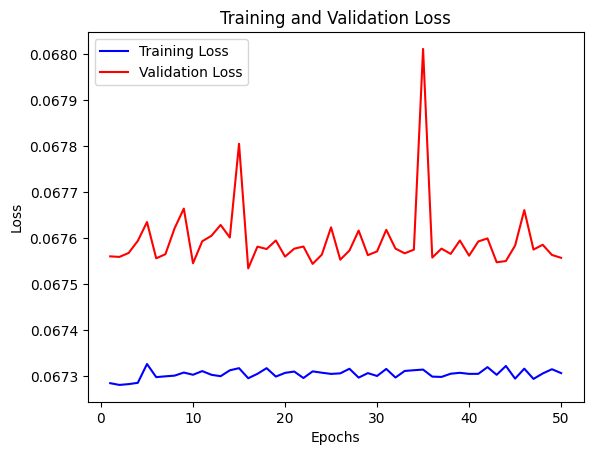

In [39]:
# Plot the training loss and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Generate predictions using the trained VAE
decoded_imgs = vae.predict(x_test)


313/313 [==============================] - 1s 2ms/step


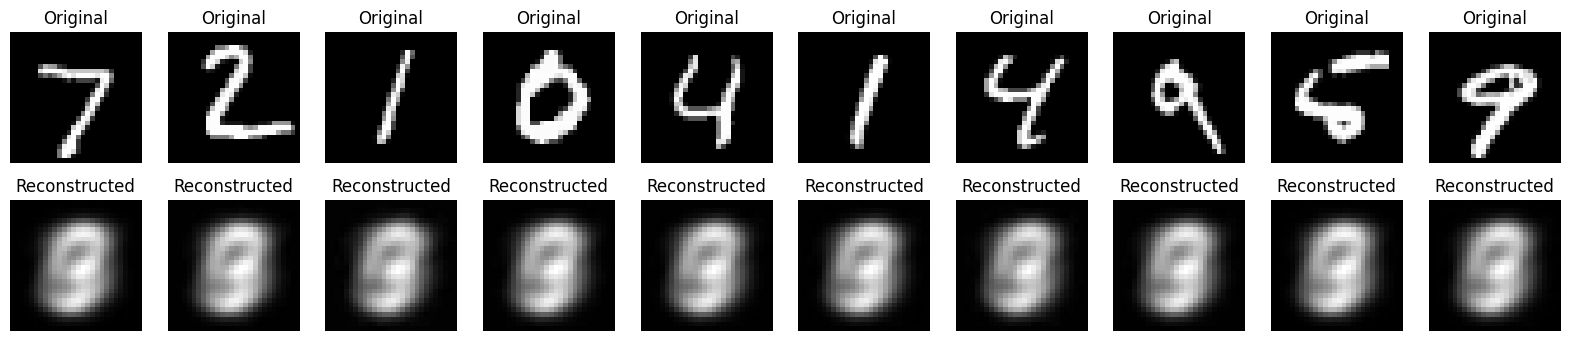

In [41]:
# Plot some input images and their corresponding reconstructions
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(image_size, image_size), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    # Display reconstructed images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()